<a href="https://colab.research.google.com/github/Marco10292/Customer-segmentation-for-targeted-marketing-campaigns/blob/main/Customer_segmentation_for_targeted_marketing_campaigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Customer segmentation for targeted marketing campaigns**

FinTech Solutions S.p.A., a leader in the financial services sector, has decided to launch a new marketing campaign to promote its line of credit cards. To optimize the effectiveness of the campaign, the company has chosen **to segment its customers** into homogeneous groups based on their *spending behaviors* and *credit card usage*.

This segmentation will enable the company to target *personalized marketing campaigns* to each customer cluster, thereby maximizing return on investment and enhancing the user experience.






**Variable names and descriptions**

CUST_ID:	Unique identifier of the credit card holder (categorical)

BALANCE:	Amount of the balance remaining on the account for purchases

BALANCE_FREQUENCY:	Frequency of balance update, with a scale from 0 to 1 (1 = frequently updated, 0 = infrequently updated)

PURCHASES:	Total amount of purchases made by the account

ONEOFF_PURCHASES:	Maximum amount of purchases made in a single transaction

INSTALLMENTS_PURCHASES:	Amount of purchases made by installments

CASH_ADVANCE:	Cash advance given by the user

PURCHASES_FREQUENCY:	Frequency of purchases, with a scale from 0 to 1 (1 = frequent purchases, 0 = infrequent purchases)

ONEOFF_PURCHASES_FREQUENCY:	Frequency of one-off purchases (1 = frequent, 0 = infrequent)

PURCHASES_INSTALLMENTS_FREQUENCY:	Frequency of installment purchases (1 = frequent, 0 = infrequent)

CASH_ADVANCE_FREQUENCY:	Frequency of cash advance requests

CASH_ADVANCE_TRX:	Number of transactions made with cash advance

PURCHASES_TRX:	Total number of purchase transactions made

CREDIT_LIMIT:	Maximum credit limit of the credit card for each user

PAYMENTS:	Total amount of payments made by the user

MINIMUM_PAYMENTS:	Minimum amount of payments made by the user

PRC_FULL_PAYMENT:	Percentage of the full payment paid by the user

TENURE:	Duration of the credit card service for the user (in years)


## Exploratory data analysis (EDA)

Missing Values:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

CUST_ID column has 0 duplicates



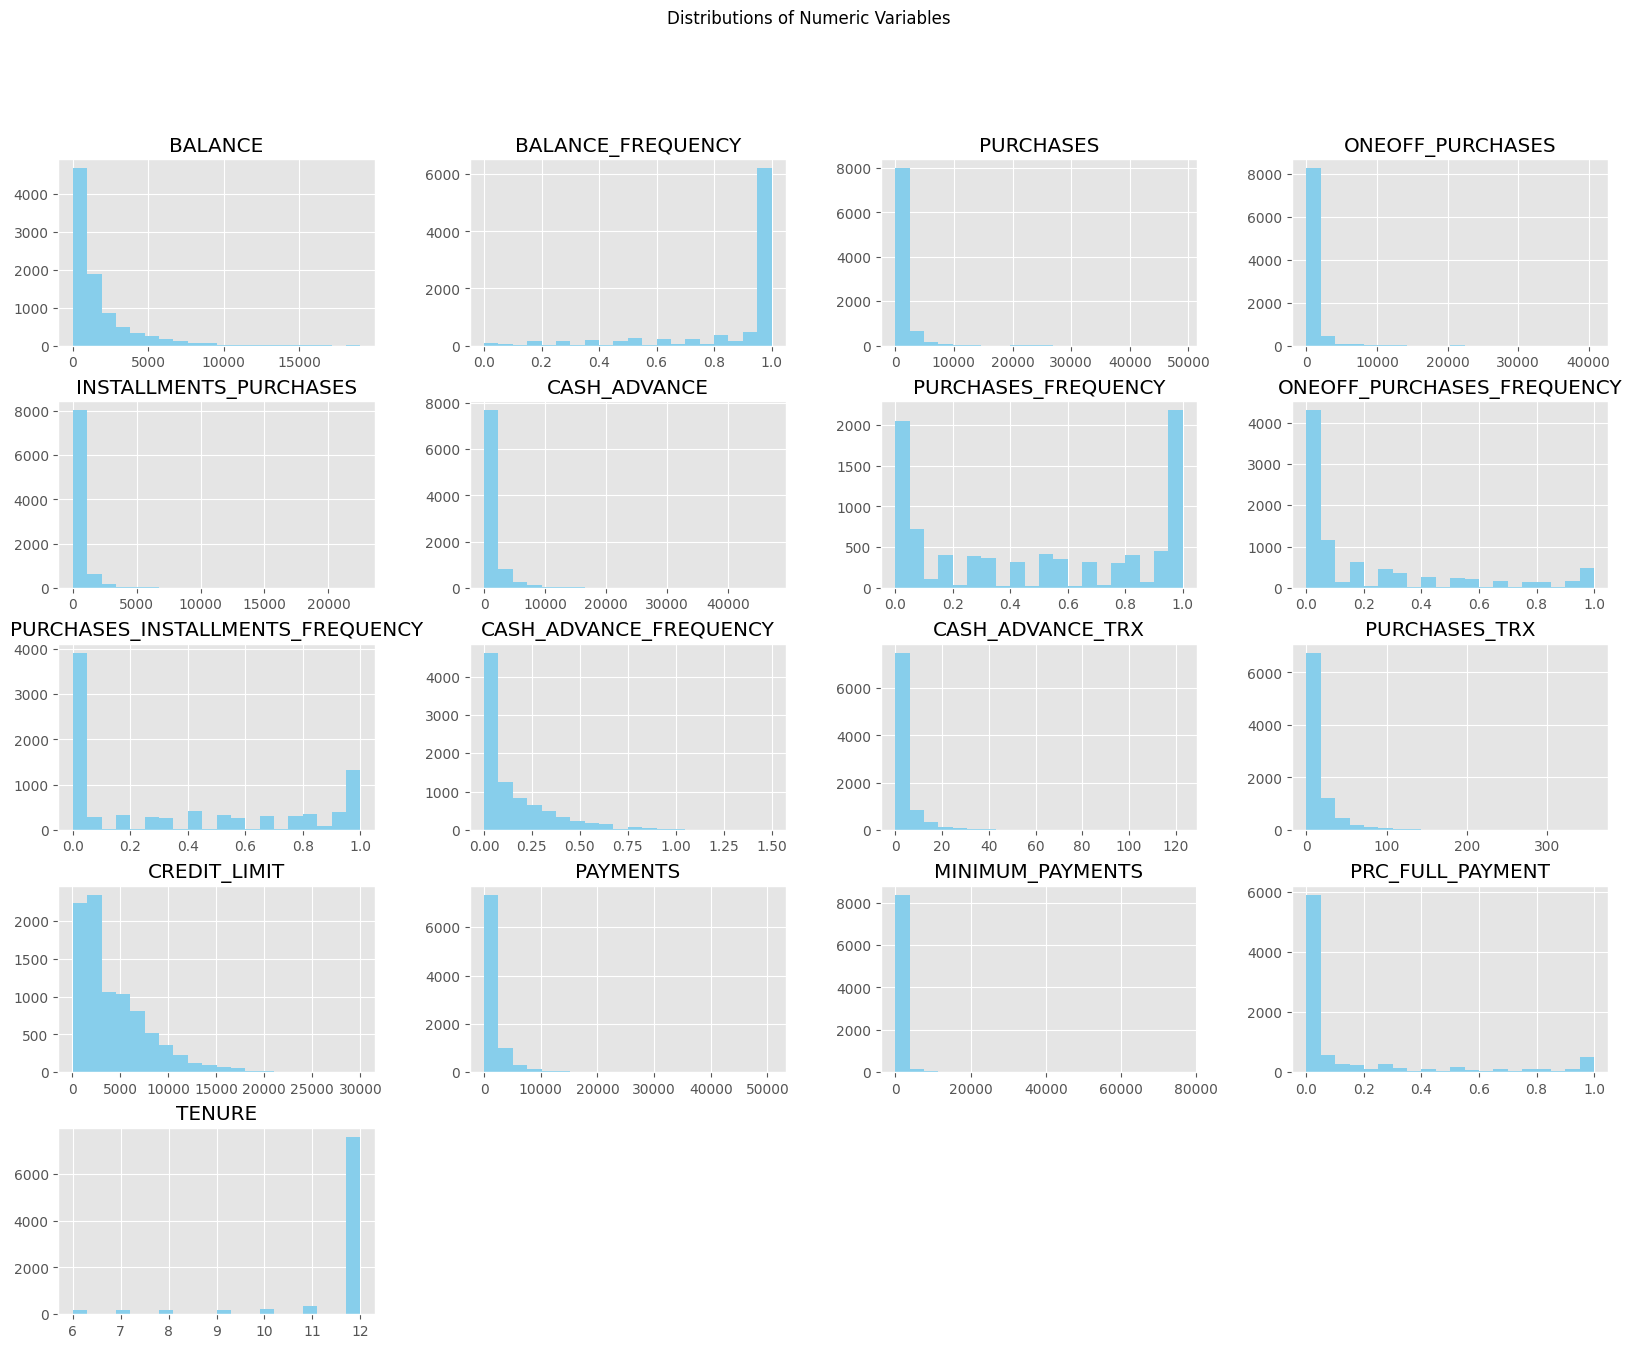

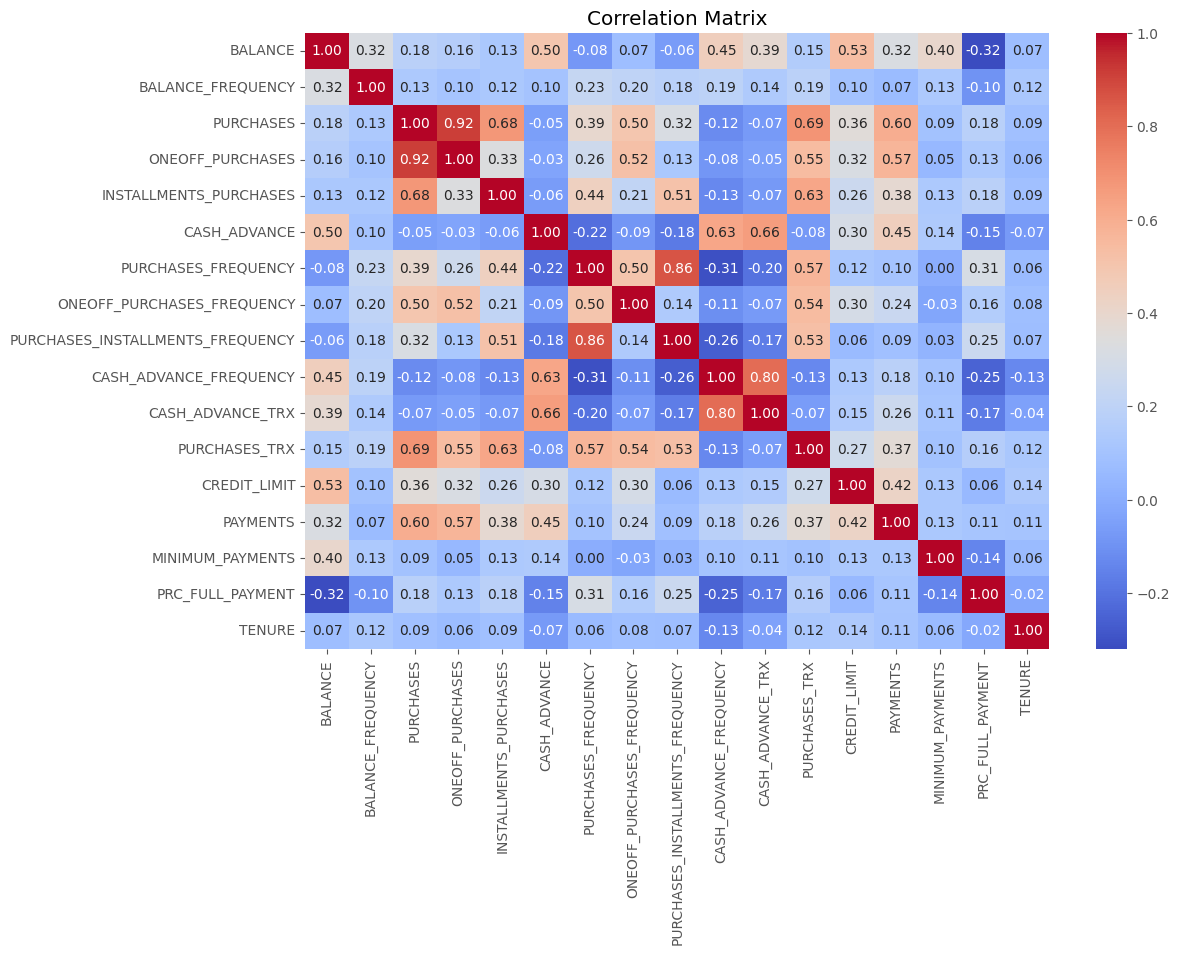

In [ ]:
### Project ProfessionAI: Marco_Gamberini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import files
plt.style.use('ggplot')

BASE_URL = "https://raw.githubusercontent.com/Marco10292/GENERALE/refs/heads/main/"
df = pd.read_csv(BASE_URL + "credit_card_customers.csv")

# 1. Exploratory data analysis (EDA)
# I check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
# Add a blank line for clarity
print()
# I want to see if each CUST_ID appears only once or not
custid_duplicates = df['CUST_ID'].duplicated().sum()
print (f"CUST_ID column has {custid_duplicates} duplicates")

# Data types per column
df.dtypes
# I visualize general distribution of numeric variables
print()
df.hist(bins=20, figsize=(20, 15), color='skyblue')
plt.suptitle('Distributions of Numeric Variables')
plt.show()
# Correlation matrix; I select only numeric columns from the original dataframe 'df'
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True) # Calculate the correlation matrix using the numeric DataFrame
plt.title("Correlation Matrix")
plt.show()

**I** dispalyed above the *distributions of all numeric variables* in a very brief and general way, to give an overall idea. Many bars are unbalanced, but it is easy to display a single variable in more details, if needed.

Moreover, I displayed a **Correlation Matrix**, to decide later which
relationships to investigate and develop further.
Note that: each of these correlation types exists in a spectrum represented by values **from -1 to +1** where slight or high positive correlation features can be like 0.5 or 0.6 A very strong and perfect positive correlation is represented by a correlation score of 0.9 or 1.



## Preprocessing
First of all, I substitute *Null values* in the columns *'MINIMUM_PAYMENTS'* and *'CREDIT_LIMIT'* which I located in EDA, with the column's **median value**, to nullify their effect on general analysis.

In [ ]:
# 2. Preprocessing
# Substitute Null values with median values
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median())

I create a function that serves the pourpose of *mitigating the outliers' value of certain columns*, which I decided to take into account for my analysis.

I apply it to a *copy* of the original dataframe, to preserve it.

Finally, I *save the cleaned* data into a new CSV.

**Note:** there are quite many inbound functions that perform a similar outliers' cleaning practice, such as the winsorize function from scipy.stats.mstats or numpy.clip for smaller tasks.

In [ ]:
# Function to clean specific numeric columns by capping their outliers
def cap_outliers(column, df):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Apply to key quantitative features
for feature in ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT']:
    cap_outliers(feature, df)
    # Standardize numeric features
scaler = StandardScaler()

# Columns to scale
numeric_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
                'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
                'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS',
                'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
# Applying scaling
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
# Save the cleaned and scaled data
df_scaled.to_csv('processed_data.csv', index=False)

## Clustering: developement


Here, I plan and execute **clustering**, one of the most common tasks in unsupervised learning within machine learning. Clustering involves grouping observations based on similar characteristics.

In practical terms, this process creates a **customer segmentation**, dividing customers into groups with shared traits. This segmentation will assist other teams in the company in tailoring their approach to customers and planning effective strategies.

In this section, we use the **K-Means** clustering algorithm *to segment data into groups based on similarity*. K-Means is an **unsupervised** machine learning technique that partitions data into a predefined number of clusters,
𝑘
It works by iteratively:

Initializing
𝑘
cluster **centroids**.
Assigning each data point to the nearest centroid (minimizing within-cluster variance).
Recomputing centroids based on the mean position of points in each cluster.
Repeating the process until convergence or until a maximum number of iterations is reached.
**The Elbow Method** is used to identify the optimal number of clusters by evaluating the total within-cluster variance (inertia). Additionally, **Silhouette Scores** help assess cluster cohesion and separation to confirm cluster quality.

After determining the **optimal
𝑘**
, the data is assigned to clusters for further analysis.


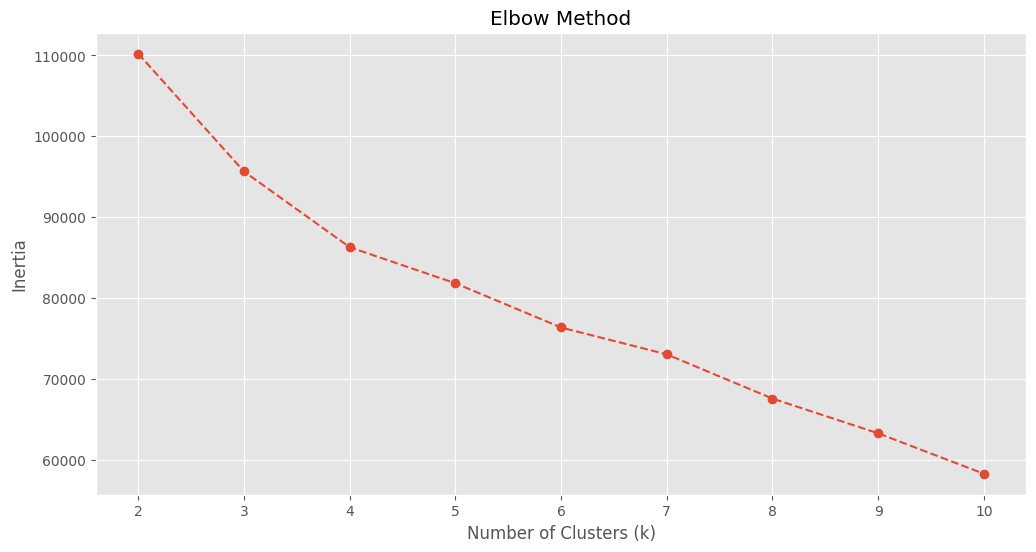

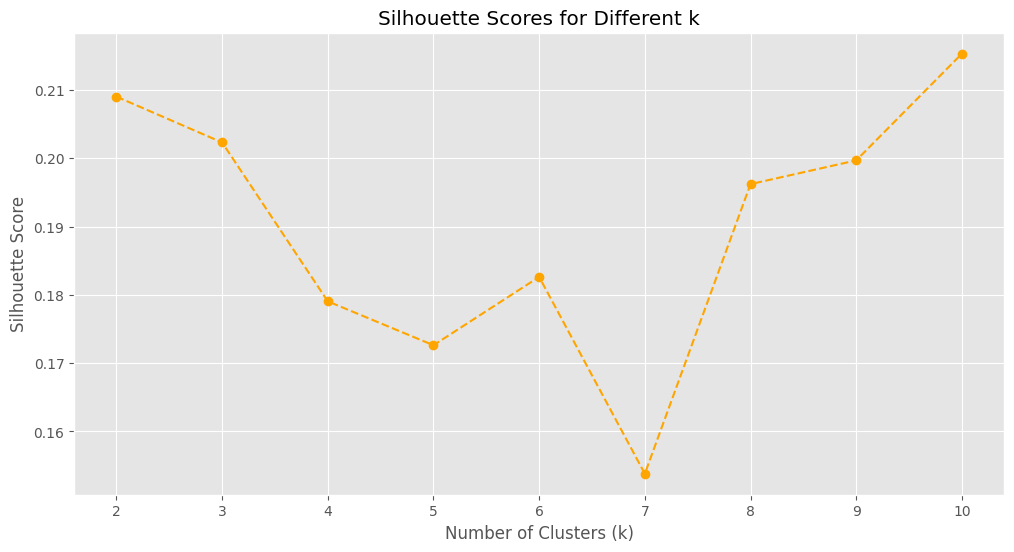

Cluster
3    3401
1    2517
2    1719
0    1313
Name: count, dtype: int64
Cluster Analysis in Original Scale:
       BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
0  1985.600677           0.974216  2396.907112       2801.346329   
1   596.885476           0.915013   793.559076        219.053464   
2  3265.635814           0.959742   309.540665        194.189820   
3   800.344873           0.770228   270.761207        217.282232   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0             1400.658751    428.084107             0.916326   
1              576.963385    127.783723             0.867145   
2              117.247103   2250.280368             0.225826   
3               54.756210    372.437183             0.180742   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.693557                          0.649108   
1                    0.153602                          0.757047   
2                    0.0985

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3. Segmentation trough Clustering
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[numeric_cols])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled[numeric_cols], kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()

# Assuming the optimal number of clusters is 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[numeric_cols])

# View the number of customers in each cluster
print(df_scaled['Cluster'].value_counts())

cluster_analysis = df_scaled.groupby('Cluster')[numeric_cols].mean()

# Convert cluster analysis back to the original scale
original_scaled_means = scaler.inverse_transform(cluster_analysis)
original_cluster_analysis = pd.DataFrame(original_scaled_means, columns=numeric_cols)

print("Cluster Analysis in Original Scale:")
print(original_cluster_analysis)

# Save the cluster analysis in original scale
original_cluster_analysis.to_excel('original_cluster_analysis.xlsx')
from google.colab import files
files.download('original_cluster_analysis.xlsx')

# Clustering: interpretation


In this step, we analyze and interpret the clusters created through the K-Means algorithm to better understand the characteristics of each group. Specifically:

**Grouping by Cluster:**
The data is grouped by the assigned cluster labels (Cluster) to compute meaningful statistics for each group.

**Average Expenses:**
The average values for key spending-related variables (BALANCE, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES) are calculated to assess typical expenditure patterns.

**Payment Habits:**
Key payment behavior metrics (MINIMUM_PAYMENTS, PRC_FULL_PAYMENT) are averaged to understand how customers in each cluster approach paying their credit card balances.

**Card Utilization Frequency:**
Metrics like CASH_ADVANCE and PURCHASES_FREQUENCY are averaged to evaluate how frequently customers use their cards and for what purpose.

**Combining Results:**
The results are concatenated into a single DataFrame for a comprehensive overview of each cluster's characteristics, making it easier to compare and interpret.

By analyzing this aggregated data, *we can derive actionable insights about each customer group*, such as spending habits, payment reliability, and card usage frequency. This helps in tailoring strategies to better serve or target these segments.

In [ ]:
# 4. Clusters' interpretation
# Group the data by cluster
clustered_data = df_scaled.groupby('Cluster')

# For Average Expenses
average_expenses = clustered_data[['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES']].mean()

# For Payment habits
payment_habits = clustered_data[['MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']].mean()

# For Card utilization frequency
card_utilization_frequency = clustered_data[['CASH_ADVANCE', 'PURCHASES_FREQUENCY']].mean()

# Combine all results into a single dataframe for better presentation
cluster_analysis = pd.concat([average_expenses, payment_habits, card_utilization_frequency], axis=1)

# Display the cluster analysis
print(cluster_analysis)

# Save the cluster analysis as an Excel file
cluster_analysis.to_excel('cluster_analysis.xlsx')

          BALANCE  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  MINIMUM_PAYMENTS  \
Cluster                                                                         
0        0.387063          1.330832                1.094332          0.145231   
1       -0.516194         -0.224958                0.183455         -0.116837   
2        1.219632         -0.239938               -0.324919          0.380689   
3       -0.383858         -0.226025               -0.394024         -0.162015   

         PRC_FULL_PAYMENT  CASH_ADVANCE  PURCHASES_FREQUENCY  
Cluster                                                       
0                0.391879     -0.244762             1.061361  
1                0.426198     -0.545526             0.938821  
2               -0.423578      1.580246            -0.659089  
3               -0.252616     -0.300495            -0.771422  


**How do I interpret these data?**
These values have been standardized (i.e., scaled) using a StandardScaler, which transforms the data to have zero mean and unit variance. This scaling allows for easier comparison between different features and clusters.



1.   *Positive values* indicate that the cluster's average is higher than the overall mean of the feature.
2.   *Negative values* indicate that the cluster's average is lower than the overall mean of the feature.
3. *Values closer to zero* indicate that the cluster's average is closer to the overall mean of the feature.


*For example:* Cluster 2 has the *highest average balance* (1,219), indicating that customers in this cluster tend to carry significantly higher outstanding balances on their credit cards compared to the average customer and other clusters.
Cluster 0 has the *highest average purchase frequency* (1.061), indicating that customers in this cluster make purchases more frequently.


Another interesting consideration may be:
*Cluster 0 has the highest average minimum payments (0.145), **but this value is close to 0. **

This suggests that even though Cluster 0 customers *have the highest minimum payment requirements among the clusters, these minimum payments are still relatively low compared to the overall distribution of minimum payments across all customers.*

This might indicate that:
1. They have low credit limits, resulting in lower minimum payment amounts.
2. They make frequent small purchases, leading to smaller minimum payments.
3. They tend to pay off a significant portion of their balance each month, leaving a lower minimum payment due.

In [ ]:
# Add the 'Cluster' column to the original (non-standardized) DataFrame
df_original_with_clusters = df.copy()  # Assuming 'df' contains the original data before scaling
df_original_with_clusters['Cluster'] = df_scaled['Cluster']  # Add the cluster column from the scaled dataset

df_original_with_clusters.to_excel('full_dataset_with_clusters_original.xlsx', index=False)

files.download('full_dataset_with_clusters_original.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Clustering visualization

Here, for a better comprehension of the clustering groups, I visualize this segmentation with PCA method.

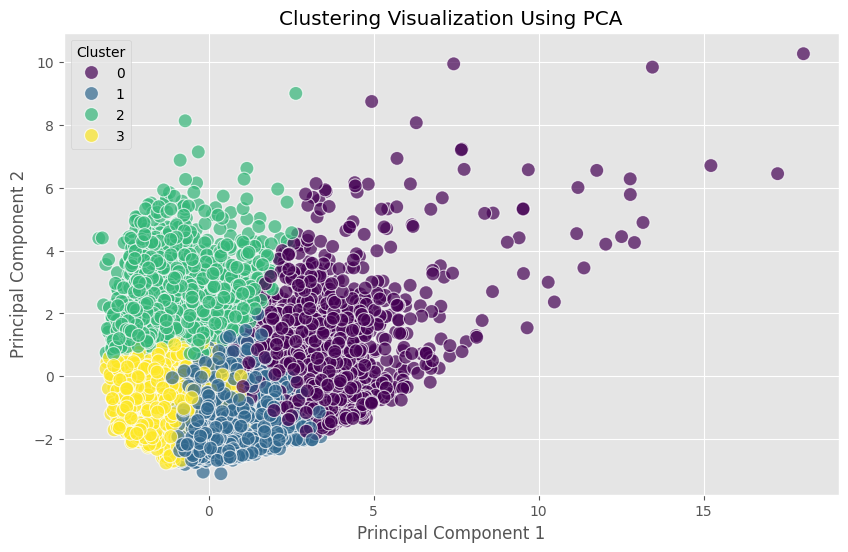

In [ ]:
# 5. Clustering visualization
from sklearn.decomposition import PCA

# Reduce dimensions to 2 using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled[numeric_cols])

# Create a DataFrame for plotting
plot_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
plot_df['Cluster'] = df_scaled['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clustering Visualization Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Text(0.5, 1.0, 'How many customers for each cluster?')

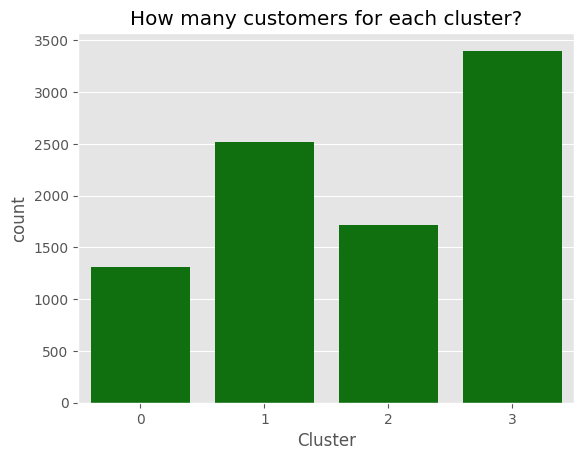

In [ ]:
# Here, I want to simply visualize the numerical distribution of Clusters
sns.countplot(x='Cluster', data=df_scaled, color='green')
plt.title('How many customers for each cluster?')

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA(n_components=2)
pca.fit(df_scaled[numeric_cols])

# Get loadings
loadings = pd.DataFrame(pca.components_.T, index=numeric_cols, columns=['PC1', 'PC2'])
print("PCA Loadings:\n", loadings)

PCA Loadings:
                                        PC1       PC2
BALANCE                           0.025217  0.493386
BALANCE_FREQUENCY                 0.127351  0.203230
PURCHASES                         0.439754  0.043578
ONEOFF_PURCHASES                  0.319813  0.139737
INSTALLMENTS_PURCHASES            0.342905  0.044370
CASH_ADVANCE                     -0.143868  0.447154
PURCHASES_FREQUENCY               0.404469 -0.142471
ONEOFF_PURCHASES_FREQUENCY        0.335238  0.057673
PURCHASES_INSTALLMENTS_FREQUENCY  0.339701 -0.146239
CASH_ADVANCE_FREQUENCY           -0.155355  0.413796
CREDIT_LIMIT                      0.192463  0.314357
PAYMENTS                          0.229598  0.290769
MINIMUM_PAYMENTS                  0.038966  0.213170
PRC_FULL_PAYMENT                  0.182486 -0.214553
TENURE                            0.095452  0.029110


## Marketing Strategies Development

In this section, we define a function *to generate targeted marketing strategies for each cluster* based on the cluster analysis. The goal is to tailor strategies to the specific characteristics and behaviors of customers within each cluster.

This approach helps develop highly customized marketing initiatives for each customer segment, improving engagement and maximizing the effectiveness of marketing efforts!

In [ ]:
# 6. Marketing strategies development
def develop_marketing_strategies(cluster_analysis):
    strategies = {}

    # Iterate over each cluster and generate strategies
    for cluster, row in cluster_analysis.iterrows():
        strategy = []

        # Strategy for Cluster 0: High spending, moderate purchases, and installment purchases
        if cluster == 0:
            strategy.append("Offer promotions for installment purchases to increase usage.")
            strategy.append("Provide incentives for paying off balances faster (e.g., lower interest rates).")
            strategy.append("Introduce loyalty programs for frequent card usage.")

        # Strategy for Cluster 1: Low spending, minimal payments, and low card usage
        elif cluster == 1:
            strategy.append("Target with small installment purchase promotions.")
            strategy.append("Offer personalized credit-building tools and engage them with financial education.")
            strategy.append("Encourage higher card usage through sign-up bonuses or cashback.")

        # Strategy for Cluster 2: High balance, frequent cash advances, low purchases
        elif cluster == 2:
            strategy.append("Introduce services related to financial management (e.g., budgeting tools).")
            strategy.append("Offer personalized credit line increases or more flexible payment options.")
            strategy.append("Provide discounts on cash advances or lower interest rates for customers with frequent cash advances.")

        # Strategy for Cluster 3: Low spending, low balance, and low card usage
        elif cluster == 3:
            strategy.append("Send personalized educational content to increase card usage.")
            strategy.append("Offer incentives for increased purchases, such as sign-up bonuses or discounts.")
            strategy.append("Introduce simple and affordable installment plans for small purchases.")

        strategies[cluster] = {
            'strategy': strategy
        }

    return strategies

# Generate marketing strategies based on the cluster analysis and display
marketing_strategies = develop_marketing_strategies(cluster_analysis)

for cluster, strategy in marketing_strategies.items():
    print(f"Cluster {cluster} Marketing Strategy:")
    for s in strategy['strategy']:
        print(f"- {s}")
    print("\n")

Cluster 0 Marketing Strategy:
- Offer promotions for installment purchases to increase usage.
- Provide incentives for paying off balances faster (e.g., lower interest rates).
- Introduce loyalty programs for frequent card usage.


Cluster 1 Marketing Strategy:
- Target with small installment purchase promotions.
- Offer personalized credit-building tools and engage them with financial education.
- Encourage higher card usage through sign-up bonuses or cashback.


Cluster 2 Marketing Strategy:
- Introduce services related to financial management (e.g., budgeting tools).
- Offer personalized credit line increases or more flexible payment options.
- Provide discounts on cash advances or lower interest rates for customers with frequent cash advances.


Cluster 3 Marketing Strategy:
- Send personalized educational content to increase card usage.
- Offer incentives for increased purchases, such as sign-up bonuses or discounts.
- Introduce simple and affordable installment plans for small pu

In [ ]:
# 7. Create an ExcelWriter object to save data to multiple sheets in one file
with pd.ExcelWriter("customer_segmentation_results.xlsx", engine="openpyxl") as writer:
    # Save cluster analysis to a sheet
    cluster_analysis.to_excel(writer, sheet_name="Cluster Analysis")

    # Save average expenses to a sheet
    average_expenses.to_excel(writer, sheet_name="Average Expenses")

    # Save payment habits to a sheet
    payment_habits.to_excel(writer, sheet_name="Payment Habits")

    # Save card utilization frequency to a sheet
    card_utilization_frequency.to_excel(writer, sheet_name="Card Utilization")

    # Convert marketing strategies to a DataFrame and save to a sheet
    strategy_list = []
    for cluster, details in marketing_strategies.items():
        for s in details['strategy']:
            strategy_list.append({'Cluster': cluster, 'Strategy': s})
    strategies_df = pd.DataFrame(strategy_list)
    strategies_df.to_excel(writer, sheet_name="Marketing Strategies", index=False)

print("All results have been exported to 'customer_segmentation_results.xlsx'.")

All results have been exported to 'customer_segmentation_results.xlsx'.
